# Workflow Debugging

In [ ]:
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


(
    training_data,
    names_list,
    scores_list,
) = Predictor.generate_trainingdata_from_qasm_files(
    folder_path="qasm_files/"  # , compiled_path="qasm_compiled_postprocessed/"
)

In [ ]:
X, y = zip(*training_data)
Predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

In [ ]:
from numpy import asarray
from numpy import save

data = asarray(training_data)
save("training_data.npy", data)
data = asarray(names_list)
save("names_list.npy", data)
data = asarray(scores_list)
save("scores_list.npy", data)

In [1]:
from numpy import asarray
from numpy import save
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

training_data = np.load("training_data.npy", allow_pickle=True)

names_list = list(np.load("names_list.npy", allow_pickle=True))

scores_list = list(np.load("scores_list.npy", allow_pickle=True))
X, y = zip(*training_data)
X = list(X)
y = list(y)
for i in range(len(X)):
    X[i] = list(X[i])
    scores_list[i] = list(scores_list[i])

Number of used and non-zero features:  26


/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best GridSearch Estimator:  DecisionTreeClassifier(max_depth=11, max_features=21, max_leaf_nodes=82,
                       min_samples_leaf=2, random_state=5)
Best GridSearch Params:  {'criterion': 'gini', 'max_depth': 11, 'max_features': 21, 'max_leaf_nodes': 82, 'min_samples_leaf': 2, 'min_samples_split': 2}
Num Training Circuits:  814
Num Test Circuits:  349
Best Training accuracy:  0.7187230174960236
Test accuracy:  0.7851002865329513
Compilation paths from Train Data:  {0, 1, 2, 3, 6, 7, 8, 11, 12, 13, 15, 16, 17}
Compilation paths from Test Data:  {0, 1, 2, 3, 6, 7, 8, 11, 12, 13, 15, 16, 17}
Compilation paths from Predictions:  {0, 1, 2, 3, 6, 7, 8, 11, 12, 15, 16, 17}
# Entries Graph:  349


/Users/nils/Documents/repos/MQTPredictor/predictor/driver.py:318: RuntimeWarning: overflow encountered in double_scalars
  plt.plot(i, tmp_res[j] / max_score, "b.", alpha=1.0, markersize=1.7)
/Users/nils/Documents/repos/MQTPredictor/predictor/driver.py:322: RuntimeWarning: overflow encountered in double_scalars
  tmp_res[y_pred_sorted_accordingly[i]] / max_score,


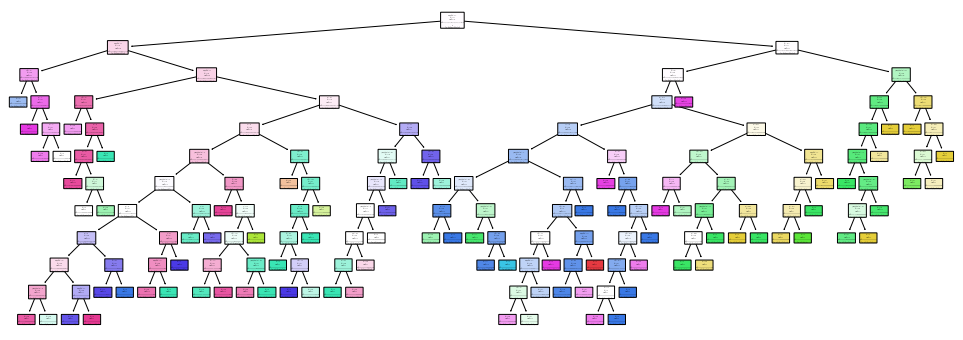

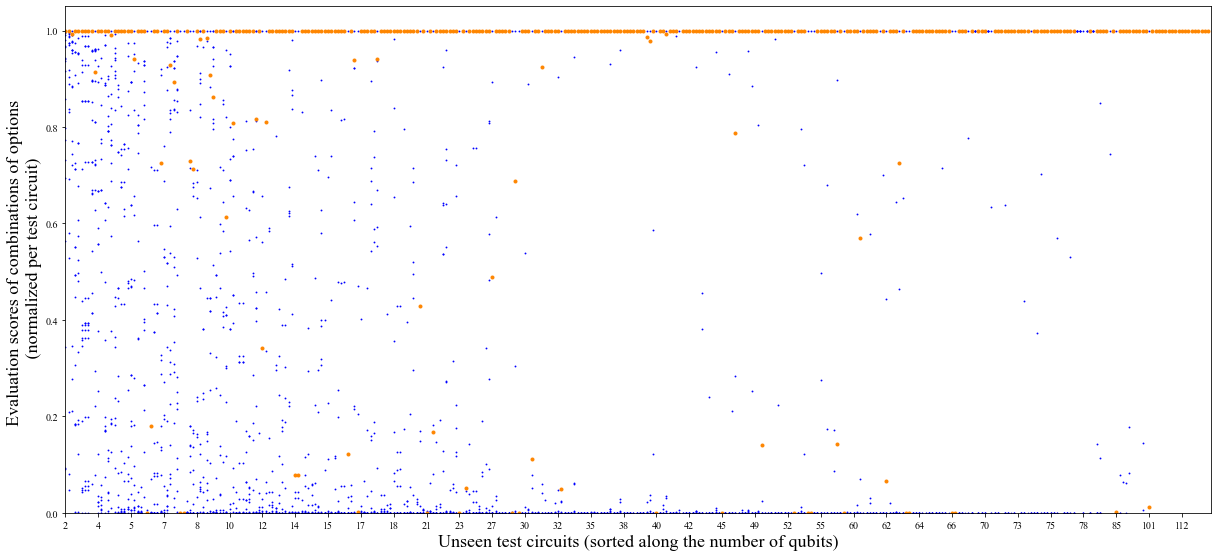

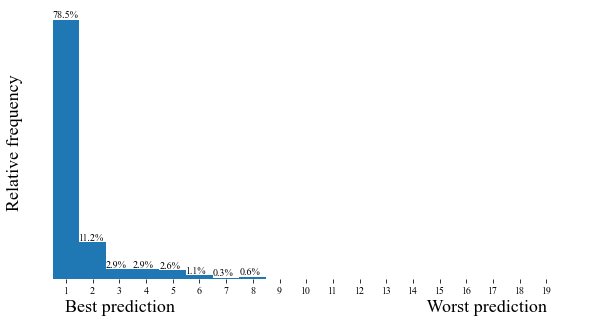

sum:  100.1


/Users/nils/miniforge3/envs/tf3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
Predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

# Decision Path Generation

In [ ]:
names_list[30]

In [ ]:
non_zero_indices = []
X = np.array(X)
y = np.array(y)
for i in range(len(X[0])):
    if sum(X[:, i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]

openqasm_qc_list = utils.get_openqasm_gates()
res = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
res.append("num_qubits")
res.append("depth")
for i in range(1, 6):
    res.append(str(i) + "_max_interactions")

res = [res[i] for i in non_zero_indices]
index = 30
X_test = X[[index]]

clf_instance = Predictor._clf.best_estimator_
n_nodes = clf_instance.tree_.node_count
children_left = clf_instance.tree_.children_left
children_right = clf_instance.tree_.children_right
feature = clf_instance.tree_.feature
threshold = clf_instance.tree_.threshold
node_indicator = clf_instance.decision_path(X_test)
leaf_id = clf_instance.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue
    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=res[feature[node_id]],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )
print("Prediction: ", clf_instance.predict(X_test))

In [ ]:
(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.3, random_state=5)
for i in range(19):
    print(y_test.count(i), utils.get_machines()[i])

In [ ]:
print(node_indicator)

# Debugging

In [ ]:
machines = utils.get_machines()
[machines[i] for i in list(Predictor._clf.classes_)]

In [ ]:
from qiskit import QuantumCircuit
from mqt.bench import get_one_benchmark

qc = get_one_benchmark("ghz", 1, 5)

# Nachbehandlung OQC qasm files

In [ ]:
import os
from qiskit import QuantumCircuit

directory = "qasm_compiled"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if "oqc_qiskit" in f:
        with open(f, "r") as f:
            lines = f.readlines()
        new_name = os.path.join("qasm_compiled_postprocessed", filename)
        with open(new_name, "w") as f:
            for line in lines:
                if not (
                    "gate rzx" in line.strip("\n") or "gate ecr" in line.strip("\n")
                ):
                    f.write(line)
                if "gate ecr" in line.strip("\n"):
                    f.write(
                        "gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }\n"
                    )
                    f.write(
                        "gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }\n"
                    )

        qc = QuantumCircuit.from_qasm_file(new_name)
        print("New qasm file for: ", new_name)

    elif "oqc_tket" in f:
        with open(f, "r") as f:
            lines = f.readlines()
        new_name = os.path.join("qasm_compiled_postprocessed", filename)
        with open(new_name, "w") as f:
            count = 0
            for line in lines:
                f.write(line)
                count += 1
                if count == 2:
                    f.write(
                        "gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }\n"
                    )
                    f.write(
                        "gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }\n"
                    )
        qc = QuantumCircuit.from_qasm_file(new_name)
        print("New qasm file for: ", new_name)

# Nachbehandlung: Check if File is readable at all

In [ ]:
import os
from qiskit import QuantumCircuit

directory = "qasm_compiled"
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if f.endswith(".qasm"):
        try:
            qc = QuantumCircuit.from_qasm_file(f)
        except Exception as e:
            print("Fail: ", e)
            # Delete file: os.remove(f)

In [ ]:
import glob

files = glob.glob("qasm_compiled/ae_indep_2_*")
print(files)

In [ ]:
np.median([i for i in range(1, 20)])